# Исследовательский анализ данных

# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:



Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.


In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
print('Размер выборки:', df.shape)

Размер выборки: (7591, 2)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


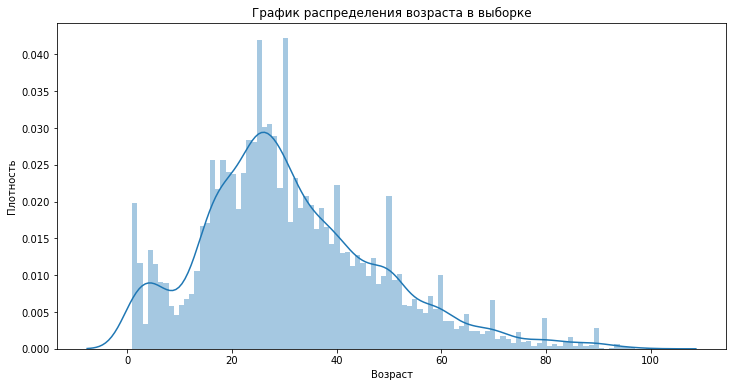

In [7]:
plt.figure(figsize=(12,6))
sns.distplot(x=df['real_age'], kde=True, bins=100)
plt.title("График распределения возраста в выборке")
plt.xlabel('Возраст')
plt.ylabel('Плотность')
plt.show()

Проверим, в каких возрастах присутствуют пики.

In [8]:
df['real_age'].value_counts().head(10)

30    317
25    315
27    229
26    226
28    217
23    213
24    211
18    193
16    193
19    180
Name: real_age, dtype: int64

Возможно, что изначально к некоторым фотографиям не было указано настоящего возраста, и им было присвоено примерное количество лет. В нашем случае, 30 и 25.

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=123)

Found 7591 validated image filenames.


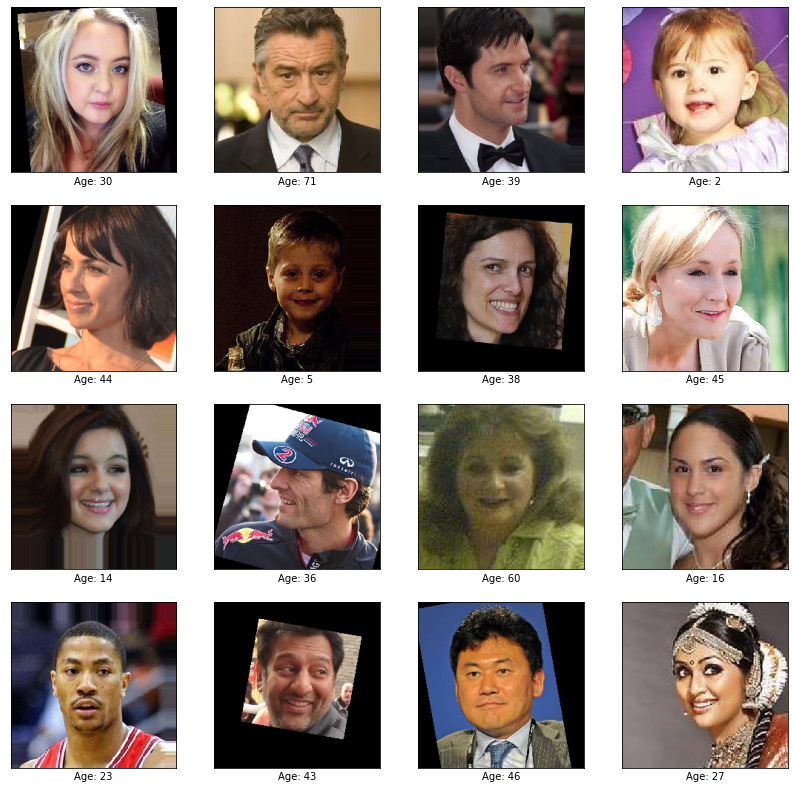

In [10]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(14, 14))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Age: {}'.format(target[i]))  # Добавление возраста

Большое количество фотографий низкого качества, в некоторых случаях люди смотрят не в камеру, выражают эмоции, что может негативно сказаться на предсказаниях модели.

## Обучение модели

from tensorflow.keras.applications.resnet import ResNet50 <br>
from tensorflow.keras.preprocessing.image import ImageDataGenerator<br>
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten<br>
from tensorflow.keras.models import Sequential<br>
from tensorflow.keras.optimizers import Adam<br>
import numpy as np<br>
import pandas as pd<br>


def load_train(path):

    labels = pd.read_csv('/datasets/faces/labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.2)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):

    labels = pd.read_csv('/datasets/faces/labels.csv')

    valid_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.2)

    validation_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)

    return validation_gen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.00001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

<b>Вывод при обучении модели</b>

Train for 190 steps, validate for 48 steps<br>
Epoch 1/20<br>
190/190 - 51s - loss: 790.1147 - mae: 23.3979 - val_loss: 1077.9452 - val_mae: 28.1295<br>
Epoch 2/20<br>
190/190 - 52s - loss: 186.8047 - mae: 10.4044 - val_loss: 1017.2812 - val_mae: 27.0851<br>
Epoch 3/20<br>
190/190 - 50s - loss: 78.5981 - mae: 6.6565 - val_loss: 803.5765 - val_mae: 23.5664<br>
Epoch 4/20<br>
190/190 - 49s - loss: 41.5629 - mae: 4.8570 - val_loss: 182.1560 - val_mae: 10.4437<br>
Epoch 5/20<br>
190/190 - 65s - loss: 24.6487 - mae: 3.7997 - val_loss: 107.8015 - val_mae: 8.0244<br>
Epoch 6/20<br>
190/190 - 61s - loss: 17.5807 - mae: 3.2319 - val_loss: 92.7630 - val_mae: 7.3790<br>
Epoch 7/20<br>
190/190 - 51s - loss: 15.0230 - mae: 2.9852 - val_loss: 88.1219 - val_mae: 7.1041<br>
Epoch 8/20<br>
190/190 - 67s - loss: 14.1336 - mae: 2.8650 - val_loss: 87.5803 - val_mae: 6.9926<br>
Epoch 9/20<br>
190/190 - 55s - loss: 13.2071 - mae: 2.7834 - val_loss: 88.8812 - val_mae: 7.2129<br>
Epoch 10/20<br>
190/190 - 58s - loss: 11.9172 - mae: 2.6729 - val_loss: 89.5960 - val_mae: 7.0395<br>
Epoch 11/20<br>
190/190 - 67s - loss: 10.9151 - mae: 2.5730 - val_loss: 89.0302 - val_mae: 7.0180<br>
Epoch 12/20<br>
Epoch 13/20<br>
190/190 - 49s - loss: 10.3484 - mae: 2.5006 - val_loss: 87.0344 - val_mae: 7.1020<br>
190/190 - 63s - loss: 10.2277 - mae: 2.4866 - val_loss: 86.0926 - val_mae: 7.0185<br>
Epoch 14/20<br>
190/190 - 66s - loss: 10.2858 - mae: 2.4951 - val_loss: 88.7218 - val_mae: 7.0643<br>
Epoch 15/20<br>
190/190 - 46s - loss: 9.8638 - mae: 2.4380 - val_loss: 85.6211 - val_mae: 7.0053<br>
Epoch 16/20<br>
190/190 - 66s - loss: 9.5439 - mae: 2.3962 - val_loss: 84.3630 - val_mae: 6.9184<br>
Epoch 17/20<br>
190/190 - 66s - loss: 8.8501 - mae: 2.2829 - val_loss: 84.3348 - val_mae: 6.9586<br>
Epoch 18/20<br>
190/190 - 42s - loss: 8.1244 - mae: 2.1938 - val_loss: 83.8160 - val_mae: 6.8696<br>
Epoch 19/20<br>
190/190 - 51s - loss: 7.4490 - mae: 2.0704 - val_loss: 84.8156 - val_mae: 6.9815<br>
Epoch 20/20<br>
190/190 - 49s - loss: 6.8433 - mae: 1.9957 - val_loss: 83.0964 - val_mae: 6.8227<br>
WARNING:tensorflow:sample_weight modes were coerced from<br>
  ...
    to  
  ['...']
48/48 - 8s - loss: 83.0964 - mae: 6.8227<br>
Test MAE: 6.8227<br>

## Анализ обученной модели

Мы обучили архитектуру ResNet50. В среднем модель ошибается на 6.82, что крайне хорошо для того качества фотографий, что представлены. По анализу обучению кажется, что архитектуру можно улучшить и добиваться идеального результата

<b>Общий вывод по проекту:</b>
В нашем распоряжении был файл с фотографиям людей и их настоящим возрастом. Цель проекта - построить модель, которая будет определять возраст человека по фотографии
1. Распределение с выборке имеет нормальный вид с пиками в 30 и 25. Мое предположение - изначально к некоторым фотографиям не было указано настоящего возраста, и им было присвоено примерное количество лет
2. Большое количество фотографий низкого качества, в некоторых случаях люди смотрят не в камеру, выражают эмоции, носят очки, что может негативно сказаться на предсказаниях модели. Также некоторые фотографии наклонены, засветлены, что также в перспективе скажется на качестве модели
3. Для обучения использовалась архитектура ResNet50. В среднем модель ошибается на 6.82, что крайне хорошо для того качества фотографий, что представлены. 
4. Если сравнить метрику на обучении и валидации, то видно, что модель сильно переобучается. Для борьбы с переобучением следует добавить больше фотографий хорошей обработки и постоянно тестировать.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы